In [1]:
pip install skfeature-chappers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pywavelets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install kymatio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import skew, kurtosis, entropy, moment
from PyEMD import EMD
from skfeature.function.similarity_based import fisher_score
from scipy.fftpack import fft
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
import pywt
from kymatio import Scattering1D

In [9]:
## READ THE DATA (it may take a few minutes)
# Read Excel-file containing healthy signals
df_healthy = pd.read_excel("Tower_Vibration_healthy.xlsx")

# Read Excel-file containing faulty signals
df_faulty = pd.read_excel("Tower_Vibration_faulty.xlsx")

# Burn-in the first 500 seconds of simulated signals (filter data frames to start after 500 seconds) 
# to ensure that data represent steady-state behavior
df_healthy = df_healthy[df_healthy['Time'] > 500]
df_faulty = df_faulty[df_faulty['Time'] > 500]

# Discard the last 200 sec 
df_healthy = df_healthy[df_healthy['Time'] <= 9800]
df_faulty = df_faulty[df_faulty['Time'] <= 9800]

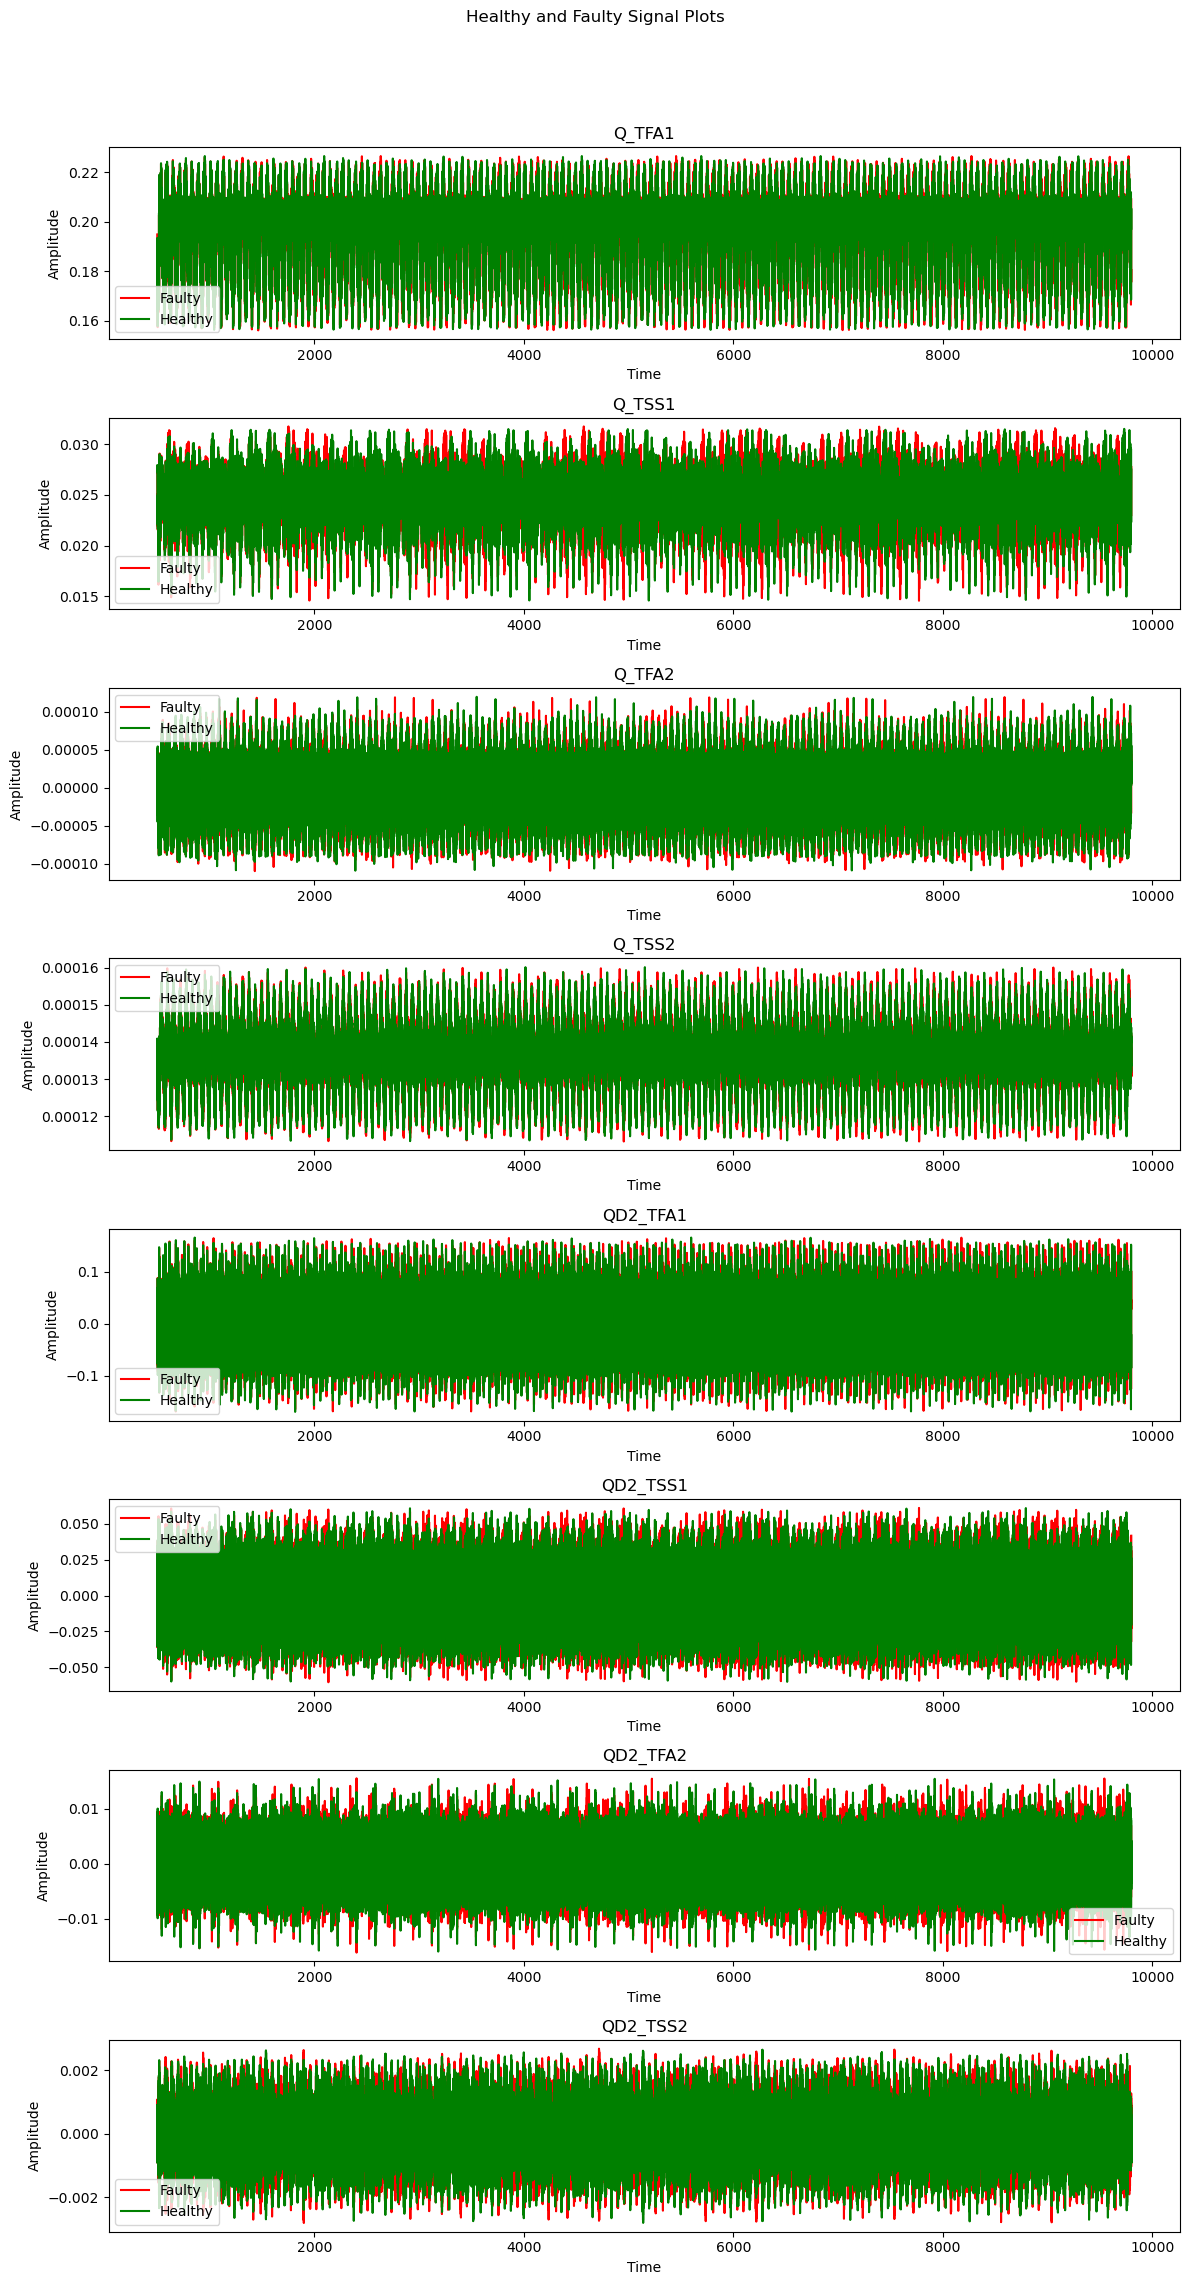

In [10]:
## DISPLAY THE ORIGINAL SIMULATED DATA (8 TIME-DOMAIN SIGNALS)
# Extract column names and signal data
columns_healthy = df_healthy.columns[1:]
columns_faulty = df_faulty.columns[1:]

# Plot healthy and faulty signals on the same subplots
fig, axs = plt.subplots(8, 1, figsize=(12, 24))
fig.suptitle('Healthy and Faulty Signal Plots')

for i, ax in enumerate(axs.flatten()):
    signal_name_healthy = columns_healthy[i]
    signal_name_faulty = columns_faulty[i]

    ax.plot(df_faulty['Time'], df_faulty[signal_name_faulty], label='Faulty', color='red')
    ax.plot(df_healthy['Time'], df_healthy[signal_name_healthy], label='Healthy', color='green')
    

    ax.set_title(signal_name_healthy)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [11]:
## CREATE DATA SET CONTAINING 10 SECONDS LONG HEALTHY AND FAULTY SIGNALS WITH LABELS (FROM THE ORIGINAL SIMULATED 9300 sec. LONG SIGNALS) 
# Initialize empty data frame to store the signals
observations_df = pd.DataFrame()
# Store healthy observations
healthy_observations = []
signal_data_healthy = df_healthy["Q_TSS1"].values
for i in range(0, len(signal_data_healthy) - 999, 1000):
    signal = signal_data_healthy[i:i+1000]
    healthy_observations.append({'Signal': 'Q_TSS1', 'Signal': signal, 'Label': 0})

# Store faulty observations
faulty_observations = []
signal_data_faulty = df_faulty["Q_TSS1"].values
for i in range(0, len(signal_data_faulty) - 999, 1000):
    signal = signal_data_faulty[i:i+1000]
    faulty_observations.append({'Signal': 'Q_TSS1', 'Signal': signal, 'Label': 1})

# Combine the healthy and faulty observations 
observations_df = pd.concat([pd.DataFrame(healthy_observations), pd.DataFrame(faulty_observations)], ignore_index=True)

# Display the resulting df
print(observations_df.head())

                                              Signal  Label
0  [0.02736, 0.02736, 0.02736, 0.02736, 0.02736, ...      0
1  [0.02418, 0.02421, 0.02424, 0.02427, 0.0243, 0...      0
2  [0.028, 0.02795, 0.02789, 0.02783, 0.02777, 0....      0
3  [0.02095, 0.02092, 0.02089, 0.02087, 0.02085, ...      0
4  [0.02529, 0.02527, 0.02526, 0.02524, 0.02522, ...      0


In [5]:
#Shape of the data set
print(observations_df.shape)

(1860, 2)


In [6]:
print(len(observations_df['Signal'].iloc[0]))

1000


1. USING MULTI-DOMAIN STATISTICAL FEATURES AS INPUT DATA FOR WIND BLADE DAMAGE DETECTION

In [12]:
## EXTRACT MULTI-DOMAIN STATISTICAL FEATURES (28 FEATURES)
# Function to calculate fourth central moment (μ₄)
def calculate_fourth_central_moment(signal):
    return moment(signal, moment=4)

# Function to calculate FM4
def calculate_FM4(signal):
    return np.sqrt(calculate_fourth_central_moment(signal)) / np.power(np.std(signal), 2)

# Function to extract features
def extract_features(row):
    signal = row['Signal']
    label = row['Label']  # Extract label
    features = {'Label': label}  # Initialize the dictionary

    # Time-domain features
    features['Mean'] = np.mean(signal)
    features['Root Mean Square'] = np.sqrt(np.mean(np.square(signal)))
    features['Root'] = np.square(np.mean(np.sqrt(np.abs(signal))))
    features['Variance'] = np.var(signal)
    features['Standard Deviation'] = np.std(signal)
    features['Skewness'] = skew(signal)
    features['Kurtosis'] = kurtosis(signal)
    features['Shape Factor'] = features['Root Mean Square'] / features['Mean']
    features['Crest Factor'] = np.max(np.abs(signal)) / features['Root Mean Square']
    features['Impulse Factor'] = np.max(np.abs(signal)) / features['Mean']
    features['Clearance Factor'] = np.max(np.abs(signal)) / np.std(signal)
    features['Skewness Factor'] = features['Skewness'] / np.power(features['Root Mean Square'], 3)
    features['Kurtosis Factor'] = features['Kurtosis'] / np.power(features['Root Mean Square'], 4)
    features['Entropy'] = entropy(signal)
    features['4thCentrMoment'] = calculate_fourth_central_moment(signal)
    features['FM4'] = calculate_FM4(signal)
    features['Median'] = np.median(signal)
    features['RSSQ'] = np.sqrt(np.sum(np.square(signal)))
    
    # Frequency-domain features
    fft_values = fft(signal)
    fft_values = fft_values[:len(fft_values)//2]  
    freq = np.fft.fftfreq(len(fft_values), d=0.01)  # Sampling rate is 100 Hz
    features['Mean Frequency'] = np.sum(freq * np.abs(fft_values)) / np.sum(np.abs(fft_values))
    features['RMS Frequency'] = np.sqrt(np.sum(np.square(freq) * np.abs(fft_values)) / np.sum(np.abs(fft_values)))
    features['Frequency Center'] = np.sum(freq * np.abs(fft_values)) / np.sum(np.abs(fft_values))
    features['Root Variance Frequency'] = np.sqrt(np.sum(np.square(freq - features['Frequency Center']) * np.abs(fft_values)) / np.sum(np.abs(fft_values)))

    # Time-frequency domain features (EMD)
    emd = EMD()
    imfs = emd(signal)
    for i in range(3):  # Extract the first 3 IMFs
        imf = imfs[i]
        features[f'IMF{i+1}_Mean'] = np.mean(imf)
        features[f'IMF{i+1}_RMS'] = np.sqrt(np.mean(np.square(imf)))

    return pd.Series(features)

# Extract multi-domain features
features_df = observations_df.apply(extract_features, axis=1)
# Display the resulting features df
print(features_df.head())

   Label      Mean  Root Mean Square      Root  Variance  Standard Deviation  \
0    0.0  0.023181          0.023262  0.023141  0.000004            0.001935   
1    0.0  0.021826          0.021989  0.021745  0.000007            0.002671   
2    0.0  0.024063          0.024180  0.024004  0.000006            0.002371   
3    0.0  0.025238          0.025302  0.025205  0.000003            0.001804   
4    0.0  0.025639          0.025681  0.025617  0.000002            0.001477   

   Skewness  Kurtosis  Shape Factor  Crest Factor  ...  Mean Frequency  \
0  0.560657  0.409597      1.003478      1.201126  ...        0.560860   
1  0.311145 -0.020583      1.007459      1.290644  ...        0.687386   
2 -0.105019 -0.689346      1.004842      1.199774  ...        1.024885   
3 -0.484868 -0.178811      1.002552      1.125596  ...        0.672667   
4 -0.035232 -0.741939      1.001659      1.118723  ...        0.325542   

   RMS Frequency  Frequency Center  Root Variance Frequency     IMF1_Mean 

In [13]:
## FEATURE SELECTION USING 2 TECHNIQUES - RANDOM FOREST FEATURE IMPORTANCE AND FISHER'S SCORE
# Extract features and labels
X = features_df.drop('Label', axis=1)  
y_sf = features_df['Label']  
# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

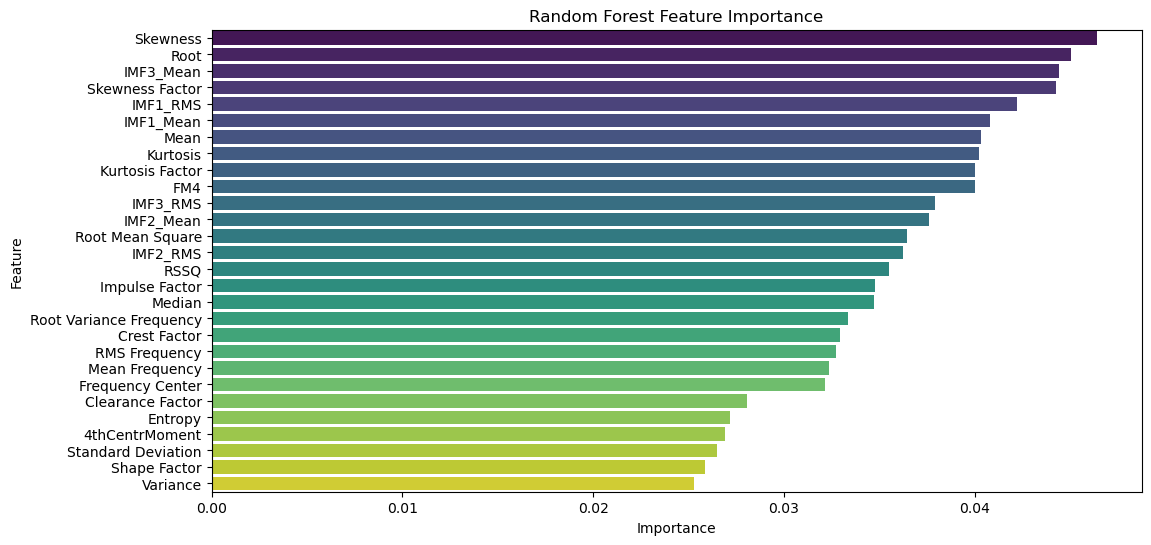

In [14]:
# Random Forest Feature Importance
model = RandomForestClassifier()
model.fit(X_scaled, y_sf)

# Feature importances
feature_importances = model.feature_importances_
# Create a data frame for visualization
feat_import_df = pd.DataFrame({'Feature': features_df.columns[1:], 'Importance': feature_importances})
feat_import_df = feat_import_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_import_df, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.show()

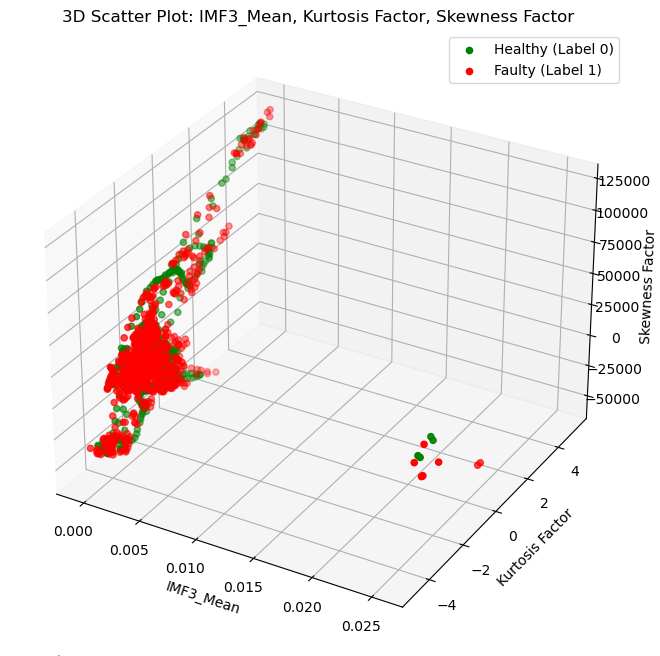

In [15]:
##DISPLAYING SOME OF THE MOST IMPORTANT FEATURES ACCORDING TO RF FEATURE IMPORTANCE

feature_x = 'IMF3_Mean'
feature_y = 'Kurtosis Factor'
feature_z = 'Skewness Factor'

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for healthy signals (Label 0)
healthy_signals = features_df[features_df['Label'] == 0]
ax.scatter(healthy_signals[feature_x], healthy_signals[feature_y], healthy_signals[feature_z], c='green', label='Healthy (Label 0)')

# Scatter plot for faulty signals (Label 1)
faulty_signals = features_df[features_df['Label'] == 1]
ax.scatter(faulty_signals[feature_x], faulty_signals[feature_y], faulty_signals[feature_z], c='red', label='Faulty (Label 1)')

ax.set_xlabel(feature_x)
ax.set_ylabel(feature_y)
ax.set_zlabel(feature_z)
ax.set_title(f'3D Scatter Plot: {feature_x}, {feature_y}, {feature_z}')
ax.legend()

plt.show()

In [11]:
print(X_scaled)

[[-0.70041765 -0.72792853 -0.685318   ... -1.16319217 -0.04828206
  -0.13578783]
 [-1.69782978 -1.67340095 -1.70760515 ... -1.27813933 -0.16619814
   0.42216613]
 [-0.05089632 -0.04580343 -0.05355402 ...  0.88866378 -0.0702348
  -0.24835187]
 ...
 [ 0.74965012  0.71726801  0.76486526 ... -0.08181308 -0.13838989
  -0.46116378]
 [ 1.12401744  1.07983096  1.14484405 ...  0.00874947 -0.19924967
  -0.35193858]
 [ 0.54658497  0.50740231  0.56593192 ... -0.20304881 -0.17384045
  -0.29323634]]


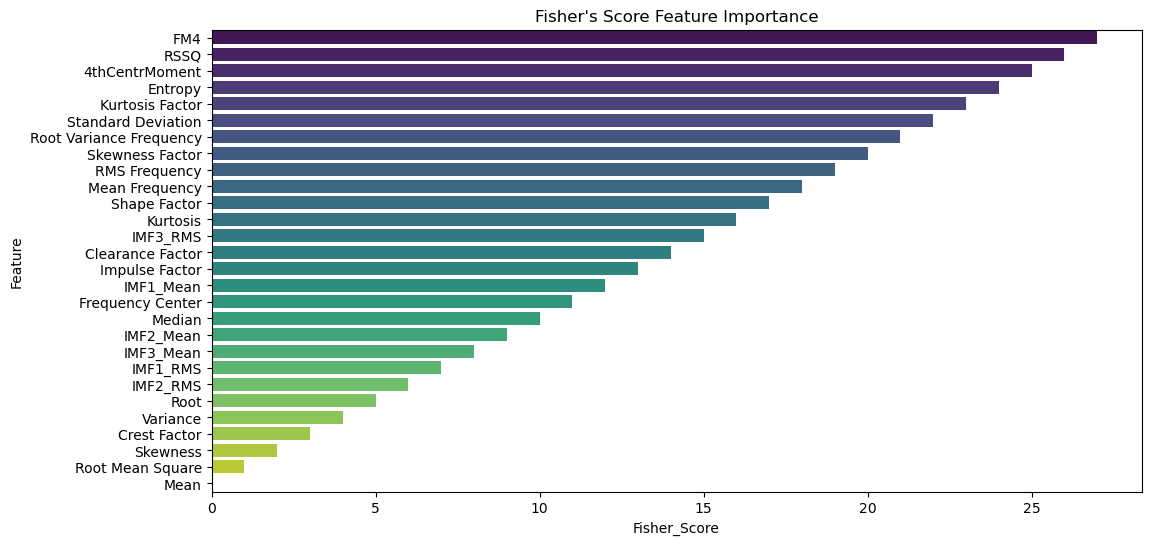

In [16]:
# Fisher's Score
# Converting y_sf into a one-dimensional numpy array
y_sf = np.asarray(y_sf).ravel()
# Calculating scores
score = fisher_score.fisher_score(X_scaled, y_sf)
# Create a data frame for visualization
fisher_score_df = pd.DataFrame({'Feature': X.columns, 'Fisher_Score': score})
fisher_score_df = fisher_score_df.sort_values(by='Fisher_Score', ascending=False)

# Plot the Fisher scores in descending order
plt.figure(figsize=(12, 6))
sns.barplot(x='Fisher_Score', y='Feature', data=fisher_score_df, palette='viridis')
plt.title("Fisher's Score Feature Importance")
plt.show()

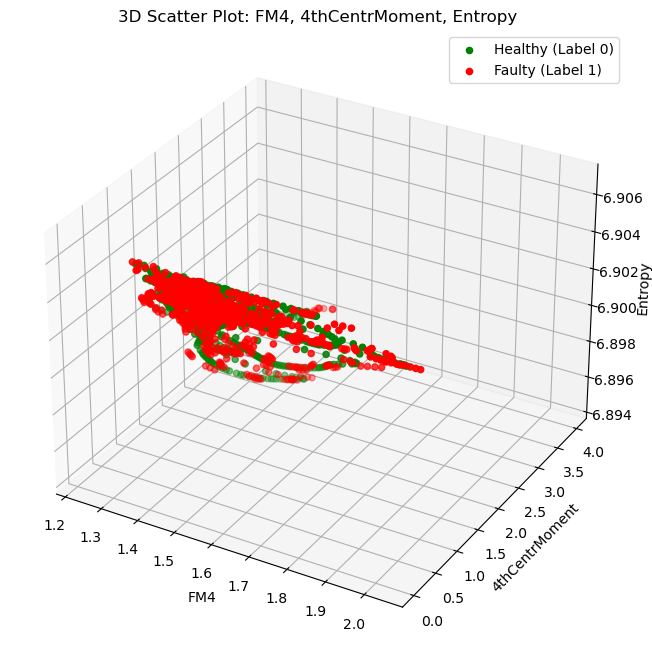

In [17]:
##DISPLAYING SOME OF THE MOST IMPORTANT FEATURES ACCORDING TO FISHER'S SCORE

feature_x = 'FM4'
feature_y = '4thCentrMoment'
feature_z = 'Entropy'

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for healthy signals (Label 0)
healthy_signals = features_df[features_df['Label'] == 0]
ax.scatter(healthy_signals[feature_x], healthy_signals[feature_y], healthy_signals[feature_z], c='green', label='Healthy (Label 0)')

# Scatter plot for faulty signals (Label 1)
faulty_signals = features_df[features_df['Label'] == 1]
ax.scatter(faulty_signals[feature_x], faulty_signals[feature_y], faulty_signals[feature_z], c='red', label='Faulty (Label 1)')

ax.set_xlabel(feature_x)
ax.set_ylabel(feature_y)
ax.set_zlabel(feature_z, labelpad=2)
ax.set_title(f'3D Scatter Plot: {feature_x}, {feature_y}, {feature_z}')
ax.legend()

plt.show()

In [18]:
# ## UNCOMMENT AND RUN THIS CODE TO PERFORM CLASSIFICATION USING THE FULL SET OF FEATURES 
# X_sf=X

In [26]:
# ## UNCOMMENT AND RUN THIS CODE TO PERFORM CLASSIFICATION USING THE REDUCED SUBSET OF FEATURES SELECTED BY RF FEATURE IMPORTANCE 
# #Select top m features
# m = 15  
# top_m_indices = feature_importances.argsort()[-m:][::-1]
# selected_features_rf = X.columns[top_m_indices]
# #print(selected_features_rf)
# #Keep only reduced subset of features
# features_df_rf = features_df[selected_features_rf]
# X_sf = features_df_rf

In [19]:
##RUN THIS CODE TO PERFORM CLASSIFICATION USING THE REDUCED SUBSET OF FEATURES SELECTED BY FISHER'S SCORE
# Select top m features
m=15
top_m_indices_fisher = score.argsort()[-m:][::-1]
selected_features_fisher = X.columns[top_m_indices_fisher]
print(selected_features_fisher)
#Keep only reduced subset of features
features_df_fisher = features_df[selected_features_fisher]
X_sf = features_df_fisher
#print(X_sf)

Index(['FM4', 'RSSQ', '4thCentrMoment', 'Entropy', 'Kurtosis Factor',
       'Standard Deviation', 'Root Variance Frequency', 'Skewness Factor',
       'RMS Frequency', 'Mean Frequency', 'Shape Factor', 'Kurtosis',
       'IMF3_RMS', 'Clearance Factor', 'Impulse Factor'],
      dtype='object')


In [20]:
# Split the dataset into training and testing sets
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(X_sf, y_sf, test_size=0.25, random_state=1)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled_sf = scaler.fit_transform(X_train_sf)
X_test_scaled_sf = scaler.transform(X_test_sf)

In [21]:
## PLEASE RUN THIS CODE TO DIRECTLY USE THE OPTIMAL MODEL PARAMETERS OBTAINED FROM HYPERPARAMETER TUNING, AND PROVIDED HERE FOR 
## YOUR CONVENIENCE TO SAVE TIME. IF NEEDED, PLEASE UNCOMMENT AND RUN THE SUBSEQUENT CHUNK OF CODE TO PERFORM HYPERPARAMETER TUNING.

# Optimal parameters for SVM (using reduced subset of 15 features selected by Fisher's Score): 
# {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
best_params_svm_sf = {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}

In [16]:
# ## HYPERPARAMETER TUNING FOR KERNELIZED SVM 

# # Originally, the parameter grid included 'poly' kernel type  along with the different options for the 'degree' parameter ('degree': [2, 3, 4]).
# #However, performing hyperparameter tuning using 'poly' kernel was computationally very expensive, taking several hours to complete.
# #None of the runs resulted in selecting the 'poly' as the optimal kernel. Thus, a decision was made to exclude the 'poly' kernel type 
# #from the parameter grid to enhance the computational efficiency of the code.

# # Parameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100, 1000],  
#     'kernel': ['rbf', 'sigmoid'],  
#     'gamma': [1, 0.1],
# }

# # Grid search object
# grid_search_svm = GridSearchCV(estimator=SVC(random_state=1),
#                                param_grid=param_grid,
#                                scoring='accuracy',
#                                cv=5,
#                                n_jobs=-1)

# # Fit grid search to the data
# grid_search_svm.fit(X_train_scaled_sf, y_train_sf)

# # Optimal parameters
# best_params_svm_sf = grid_search_svm.best_params_
# print("Optimal parameters for SVM:", best_params_svm_sf)

Optimal parameters for SVM: {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}


In [22]:
# SVM with optimal parameters
best_svm_model_sf = SVC(**best_params_svm_sf, probability=True, random_state=1)

# Train the model with the optimal parameters
best_svm_model_sf.fit(X_train_scaled_sf, y_train_sf)

# Predictions on the test data
y_pred_svm_sf = best_svm_model_sf.predict(X_test_scaled_sf)

Accuracy (SVM with best parameters): 0.8494623655913979


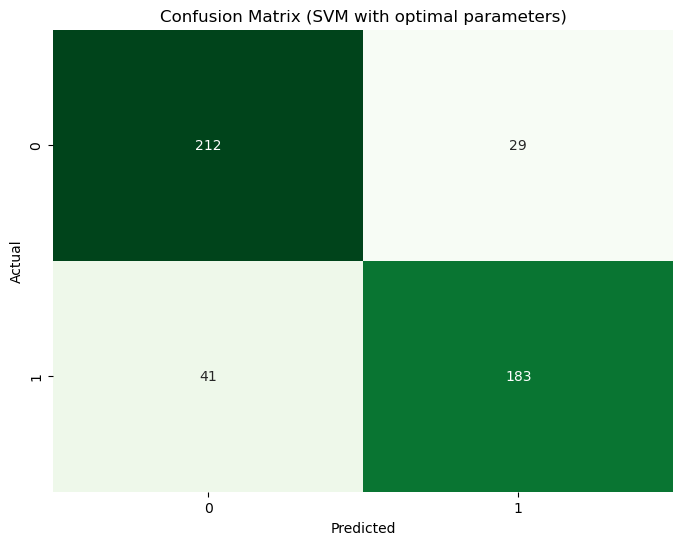

Precision (SVM): 0.8632075471698113
Recall (SVM): 0.8169642857142857
F1 Score (SVM): 0.8394495412844037


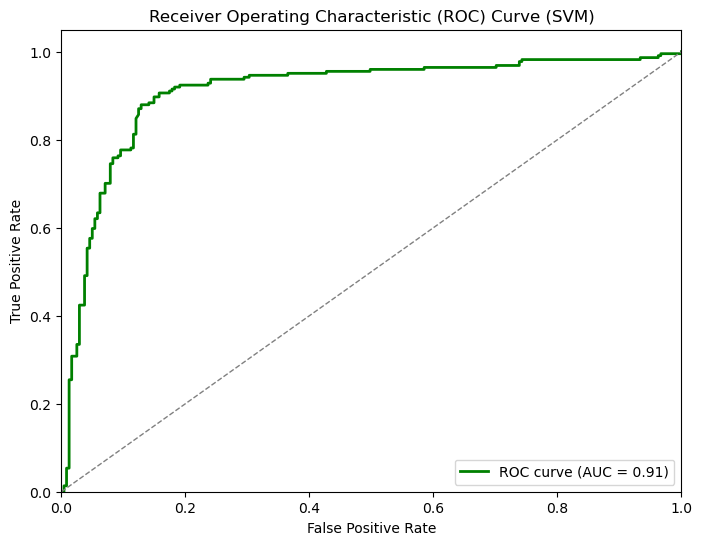

In [23]:
## SVM EVALUATION METRICS
# SVM accuracy with optimal parameters
accuracy_svm_sf = accuracy_score(y_test_sf, y_pred_svm_sf)
print("Accuracy (SVM with best parameters):", accuracy_svm_sf)

# Confusion Matrix
cm_svm_sf = confusion_matrix(y_test_sf, y_pred_svm_sf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_sf, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix (SVM with optimal parameters)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision
precision_svm_sf = precision_score(y_test_sf, y_pred_svm_sf)
print("Precision (SVM):", precision_svm_sf)

# Recall (Sensitivity)
recall_svm_sf = recall_score(y_test_sf, y_pred_svm_sf)
print("Recall (SVM):", recall_svm_sf)

# F1 Score
f1_svm_sf = f1_score(y_test_sf, y_pred_svm_sf)
print("F1 Score (SVM):", f1_svm_sf)

# ROC Curve and AUC
fpr_svm_sf, tpr_svm_sf, thresholds_svm_sf = roc_curve(y_test_sf, best_svm_model_sf.predict_proba(X_test_scaled_sf)[:, 1])
roc_auc_svm_sf = auc(fpr_svm_sf, tpr_svm_sf)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm_sf, tpr_svm_sf, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_svm_sf)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (SVM)')
plt.legend(loc="lower right")
plt.show()

In [25]:
## PLEASE RUN THIS CODE TO DIRECTLY USE THE OPTIMAL MODEL PARAMETERS OBTAINED FROM HYPERPARAMETER TUNING, AND PROVIDED HERE FOR 
## YOUR CONVENIENCE TO SAVE TIME. IF NEEDED, PLEASE UNCOMMENT AND RUN THE SUBSEQUENT CHUNK OF CODE TO PERFORM HYPERPARAMETER TUNING.

# Optimal Parameters (using reduced subset of 15 features selected by Fisher's Score): 
# {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 1000}
best_params_gbm_sf = {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 1000}

In [26]:
# ##HYPERPARAMETER TUNING FOR GBM
# #Parameter grid
# param_grid = {
#     'n_estimators': [100, 500, 1000, 1300],  # Number of trees
#     'learning_rate': [0.01, 0.1, 0.5, 0.7],  # Learning rate
#     'max_depth': [3, 4, 5],  # Maximum depth of tree
#     'min_samples_split': [3, 5, 10, 20]  # Minimum number of samples to split the node
# }

# #Grid search object
# grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1),
#                            param_grid=param_grid,
#                            scoring='accuracy',
#                            cv=3,
#                            n_jobs=-1)

# grid_search.fit(X_train_scaled_sf, y_train_sf)

# #Optimal parameters
# best_params_gbm_sf = grid_search.best_params_
# print("Optimal Parameters:", best_params_gbm_sf)

KeyboardInterrupt: 

In [27]:
#GBM with optimal parameters
best_gbm_model_sf = GradientBoostingClassifier(**best_params_gbm_sf, random_state=1)

# Train the model with the optimal parameters
best_gbm_model_sf.fit(X_train_scaled_sf, y_train_sf)

# Predictions on the test data
y_pred_gbm_sf = best_gbm_model_sf.predict(X_test_scaled_sf)

Accuracy (GBM with optimal parameters): 0.7569892473118279


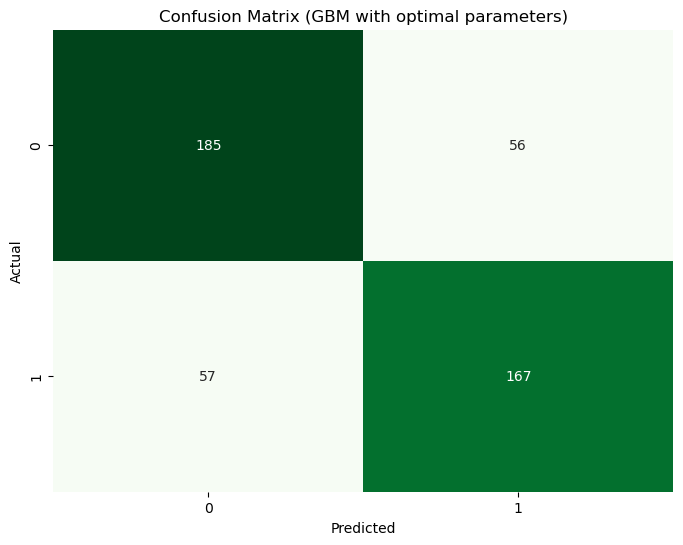

Precision (GBM): 0.7488789237668162
Recall (GBM): 0.7455357142857143
F1 Score (GBM): 0.7472035794183446


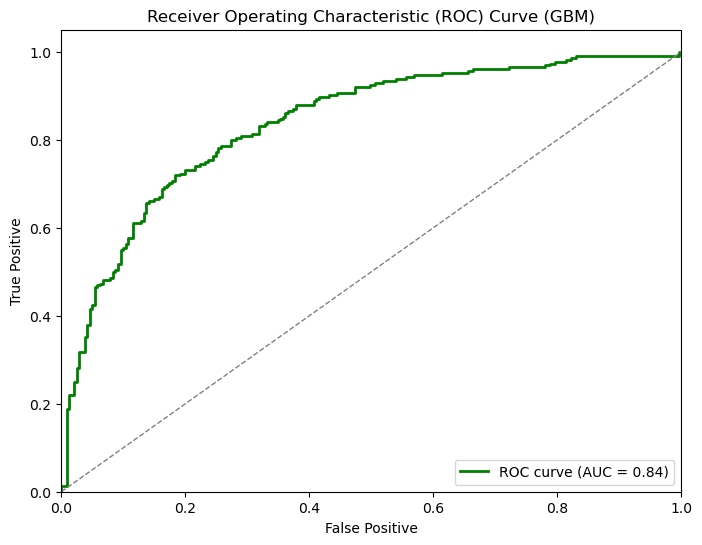

In [28]:
## GBM EVALUATION METRICS
# GBM accuracy with optimal parameters
accuracy_gbm_sf = accuracy_score(y_test_sf, y_pred_gbm_sf)
print("Accuracy (GBM with optimal parameters):", accuracy_gbm_sf)

# Confusion Matrix
cm_gbm_sf = confusion_matrix(y_test_sf, y_pred_gbm_sf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbm_sf, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix (GBM with optimal parameters)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision
precision_gbm_sf = precision_score(y_test_sf, y_pred_gbm_sf)
print("Precision (GBM):", precision_gbm_sf)

# Recall (Sensitivity)
recall_gbm_sf = recall_score(y_test_sf, y_pred_gbm_sf)
print("Recall (GBM):", recall_gbm_sf)

# F1 Score
f1_gbm_sf = f1_score(y_test_sf, y_pred_gbm_sf)
print("F1 Score (GBM):", f1_gbm_sf)

# ROC Curve and AUC
fpr_gbm_sf, tpr_gbm_sf, thresholds_gbm_sf = roc_curve(y_test_sf, best_gbm_model_sf.predict_proba(X_test_scaled_sf)[:, 1])
roc_auc_gbm_sf = auc(fpr_gbm_sf, tpr_gbm_sf)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm_sf, tpr_gbm_sf, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_gbm_sf)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('Receiver Operating Characteristic (ROC) Curve (GBM)')
plt.legend(loc="lower right")
plt.show()

In [29]:
## CLASSIFICATION ACCURACY OBTAINED THROUGH 5-FOLD CROSS-VALIDATION
# Feature scaling 
scaler = StandardScaler()
X_scaled_sf = scaler.fit_transform(X_sf)

# SVM accuracy obtained through cross-validation
svm_cv_acc_sf = cross_val_score(best_svm_model_sf, X_scaled_sf, y_sf, cv=5, scoring='accuracy')
print("SVM Cross-Validation Accuracy:", svm_cv_acc_sf.mean())

# GBM accuracy obtained through cross-validation
gbm_cv_acc_sf = cross_val_score(best_gbm_model_sf, X_scaled_sf, y_sf, cv=5, scoring='accuracy')
print("GBM Cross-Validation Accuracy:", gbm_cv_acc_sf.mean())


SVM Cross-Validation Accuracy: 0.9021505376344086
GBM Cross-Validation Accuracy: 0.8198924731182796


2. USING FFT AMPLITUDES AS INPUT DATA FOR WIND BLADE DAMAGE DETECTION 

In [30]:
## FAST FOURIER TRANSFORM(FFT)
# Extract FFT amplitudes
def extract_fft_amplit(signal):
    # Apply FFT
    fft = np.fft.fft(signal)
    
    # Calculate magnitudes
    magnitudes = np.abs(fft)
    
    # Number of samples
    N = len(signal)
    
    # Sampling frequency
    Fs = 100  
    
    # Frequency range
    frequency_range = np.fft.fftfreq(N, 1/Fs)
    
    
    return magnitudes

# Apply FFT to each observation and calculate amplitudes
observations_df['FFT_Amplitudes'] = observations_df['Signal'].apply(extract_fft_amplit)

# Create a new data frame with FFT amplitudes and labels
labels = observations_df['Label']
FFT_df = pd.DataFrame(observations_df['FFT_Amplitudes'].tolist(), index=observations_df.index)
FFT_df['Label'] = labels

# Display the resulting data frame and its shape
print(FFT_df.head())
print(FFT_df.shape)

          0         1         2         3         4         5         6  \
0  23.18088  0.751266  0.535090  0.841496  0.467739  0.038721  0.049263   
1  21.82621  0.722088  0.243762  1.501911  0.754773  0.169686  0.156963   
2  24.06305  0.141711  0.152406  1.288400  0.651035  0.575886  0.307681   
3  25.23774  0.311806  0.277383  0.856513  0.652487  0.399647  0.170239   
4  25.63854  0.148949  0.143217  0.629000  0.633165  0.431562  0.138580   

          7         8         9  ...       991       992       993       994  \
0  0.056161  0.060084  0.125763  ...  0.125763  0.060084  0.056161  0.049263   
1  0.112124  0.116202  0.101795  ...  0.101795  0.116202  0.112124  0.156963   
2  0.189531  0.160642  0.123486  ...  0.123486  0.160642  0.189531  0.307681   
3  0.085406  0.088985  0.079072  ...  0.079072  0.088985  0.085406  0.170239   
4  0.067123  0.029475  0.098588  ...  0.098588  0.029475  0.067123  0.138580   

        995       996       997       998       999  Label  
0  0.03

In [31]:
#Extract features and labels
X_fft = FFT_df.drop('Label', axis=1)  
y_fft = FFT_df['Label'] 

#Split the data into training and testing sets
X_train_fft, X_test_fft, y_train_fft, y_test_fft = train_test_split(X_fft, y_fft, test_size=0.25, random_state=1)

#Scale the features
scaler = StandardScaler()
X_train_scaled_fft = scaler.fit_transform(X_train_fft)
X_test_scaled_fft = scaler.transform(X_test_fft)

In [32]:
#Performing PCA for dimensionality reduction
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_scaled_fft)
X_test_pca = pca.transform(X_test_scaled_fft)


Total Variance Explained by the first 10 Principal Components: 0.997752


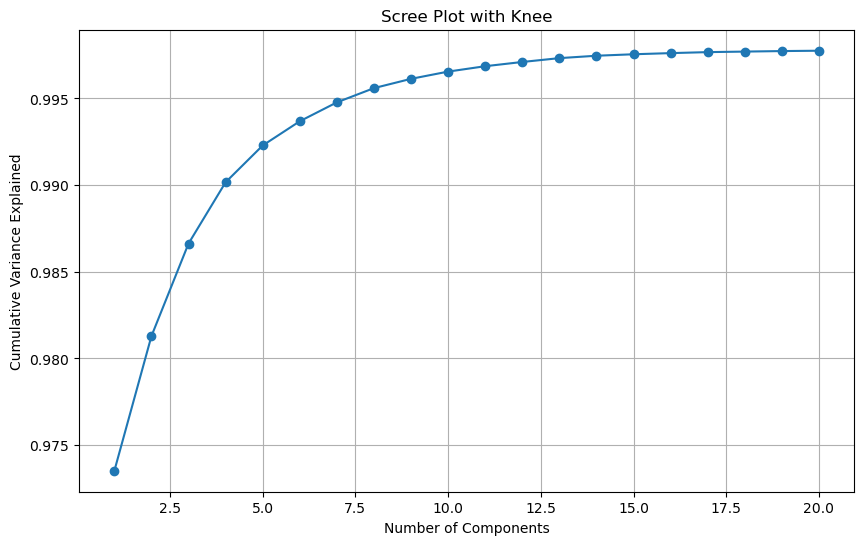

In [33]:
# Variability explained by each of the 20 principal components (PCs)
explained_variance_ratio = pca.explained_variance_ratio_
total_variance_explained = sum(explained_variance_ratio)

# Print the total variance explained by the first 10 principal components
print(f"\nTotal Variance Explained by the first 10 Principal Components: {total_variance_explained:.6f}")

# Cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree plot 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Scree Plot with Knee')
plt.grid(True)

plt.show()

In [34]:
# Selecting top 10 principal components for classification
X_train_pca = X_train_pca[:, :10]
X_test_pca = X_test_pca[:, :10]
print(X_train_pca)

[[-33.22879598  -1.1195107    0.66404431 ...  -0.09725256   0.34255394
    0.41379208]
 [ 32.04591421   1.38986101   4.18938076 ...   0.40268109  -0.25801246
    1.16344299]
 [-12.53651735   0.43221379  -1.80552079 ...   0.70934238  -0.35603049
   -0.70676679]
 ...
 [-48.61590213   5.48142984  -0.43970956 ...   1.27372095  -0.17483025
   -0.40163278]
 [ -8.51797592  -2.77476521  -1.56186718 ...  -0.54456937  -1.69432228
    0.14677042]
 [ 61.82932725   2.85497246  -1.48607966 ...   1.69845588  -0.27991771
   -0.14095373]]


In [35]:
## PLEASE RUN THIS CODE TO DIRECTLY USE THE OPTIMAL MODEL PARAMETERS OBTAINED FROM HYPERPARAMETER TUNING, AND PROVIDED HERE FOR 
## YOUR CONVENIENCE TO SAVE TIME. IF NEEDED, PLEASE UNCOMMENT AND RUN THE SUBSEQUENT CHUNK OF CODE TO PERFORM HYPERPARAMETER TUNING.

# Optimal parameters for SVM:
# {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
best_params_svm_fft = {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [36]:
# ## HYPERPARAMETER TUNING FOR KERNELIZED SVM

# # Originally, the parameter grid included 'poly' kernel type  along with the different options for the 'degree' parameter ('degree': [2, 3, 4]).
# #However, performing hyperparameter tuning using 'poly' kernel was computationally very expensive, taking several hours to complete.
# #None of the runs resulted in selecting the 'poly' as the optimal kernel. Thus, a decision was made to exclude the 'poly' kernel type 
# #from the parameter grid to enhance the computational efficiency of the code.

# # Parameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100, 1000],  
#     'kernel': ['rbf', 'sigmoid'],  
#     'gamma': [1, 0.1, 0.01],
# }

# # Grid search object
# grid_search_svm = GridSearchCV(estimator=SVC(random_state=1),
#                                param_grid=param_grid,
#                                scoring='accuracy',
#                                cv=5,
#                                n_jobs=-1)

# # Fit grid search to the data
# grid_search_svm.fit(X_train_pca, y_train_fft)

# # Optimal parameters
# best_params_svm_fft = grid_search_svm.best_params_
# print("Optimal parameters for SVM:", best_params_svm_fft)

Optimal parameters for SVM: {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [36]:
# SVM with optimal parameters
best_svm_model_fft = SVC(**best_params_svm_fft, probability=True, random_state=1)

# Train the model with the optimal parameters
best_svm_model_fft.fit(X_train_pca, y_train_fft)

# Predictions on the test data
y_pred_svm_fft = best_svm_model_fft.predict(X_test_pca)

Accuracy (SVM with best parameters): 0.7655913978494624


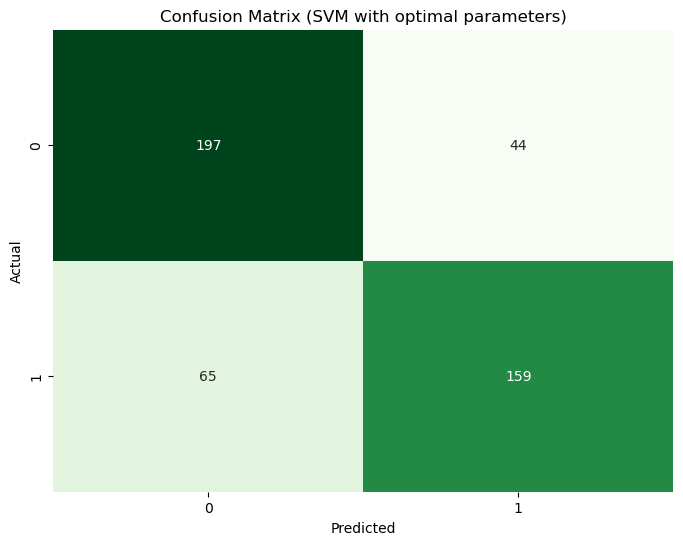

Precision (SVM): 0.7832512315270936
Recall (SVM): 0.7098214285714286
F1 Score (SVM): 0.7447306791569086


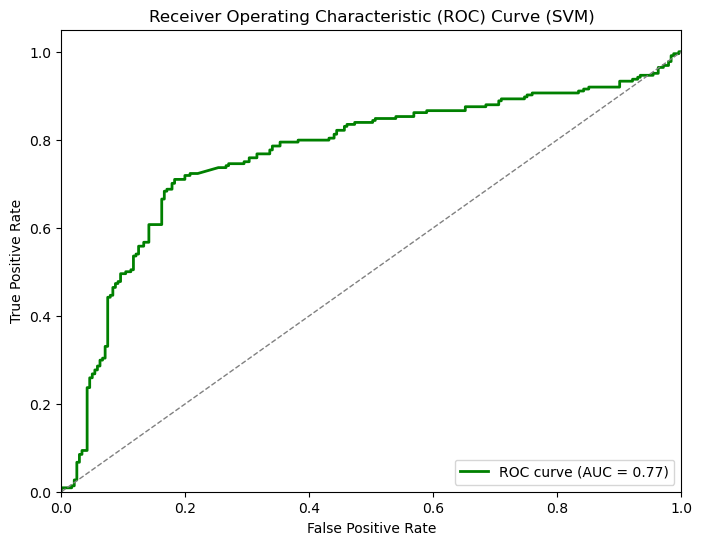

In [37]:
## SVM EVALUATION METRICS
# SVM accuracy with optimal parameters
accuracy_svm_fft = accuracy_score(y_test_fft, y_pred_svm_fft)
print("Accuracy (SVM with best parameters):", accuracy_svm_fft)

# Confusion Matrix
cm_svm = confusion_matrix(y_test_fft, y_pred_svm_fft)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix (SVM with optimal parameters)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision
precision_svm_fft = precision_score(y_test_fft, y_pred_svm_fft)
print("Precision (SVM):", precision_svm_fft)

# Recall (Sensitivity)
recall_svm_fft = recall_score(y_test_fft, y_pred_svm_fft)
print("Recall (SVM):", recall_svm_fft)

# F1 Score
f1_svm_fft = f1_score(y_test_fft, y_pred_svm_fft)
print("F1 Score (SVM):", f1_svm_fft)

# ROC Curve and AUC
fpr_svm_fft, tpr_svm_fft, thresholds_svm_fft = roc_curve(y_test_fft, best_svm_model_fft.predict_proba(X_test_pca)[:, 1])
roc_auc_svm_fft = auc(fpr_svm_fft, tpr_svm_fft)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm_fft, tpr_svm_fft, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_svm_fft)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (SVM)')
plt.legend(loc="lower right")
plt.show()

In [38]:
## PLEASE RUN THIS CODE TO DIRECTLY USE THE OPTIMAL MODEL PARAMETERS OBTAINED FROM HYPERPARAMETER TUNING, AND PROVIDED HERE FOR 
## YOUR CONVENIENCE TO SAVE TIME. IF NEEDED, PLEASE UNCOMMENT AND RUN THE SUBSEQUENT CHUNK OF CODE TO PERFORM HYPERPARAMETER TUNING.

# Optimal Parameters for GBM: 
# {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 1000}
best_params_gbm_fft = {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 1000}

In [40]:
# ## HYPERPARAMETER TUNING FOR GBM
# # Parameter grid
# param_grid = {
#     'n_estimators': [100, 500, 1000, 1300],  # Number of trees
#     'learning_rate': [0.01, 0.1, 0.5],        # Learning rate
#     'max_depth': [3, 4, 5],                   # Maximum depth of tree
#     'min_samples_split': [3, 5, 10]           # Minimum number of samples to split the node
# }

# # Grid search object
# grid_search_gbm = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1),
#                                param_grid=param_grid,
#                                scoring='accuracy',
#                                cv=5,
#                                n_jobs=-1)

# # Fit grid search to the data
# grid_search_gbm.fit(X_train_pca, y_train_fft)

# # Optimal parameters
# best_params_gbm_fft = grid_search_gbm.best_params_
# print("Optimal parameters for GBM:", best_params_gbm_fft)

Optimal parameters for GBM: {'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 1000}


In [39]:
#GBM with optimal parameters
best_gbm_model_fft = GradientBoostingClassifier(**best_params_gbm_fft, random_state=1)

# Train the model with the optimal parameters
best_gbm_model_fft.fit(X_train_pca, y_train_fft)

# Predictions on the test data
y_pred_gbm_fft = best_gbm_model_fft.predict(X_test_pca)

Accuracy (GBM with best parameters): 0.832258064516129


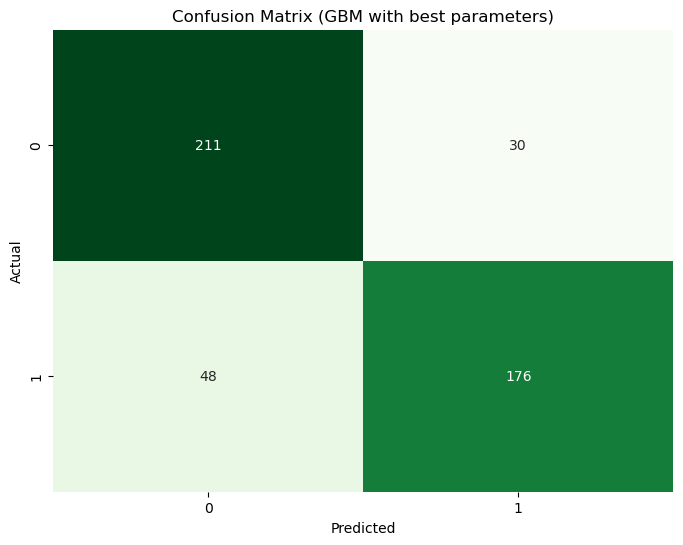

Precision (GBM): 0.8543689320388349
Recall (GBM): 0.7857142857142857
F1 Score (GBM): 0.8186046511627907


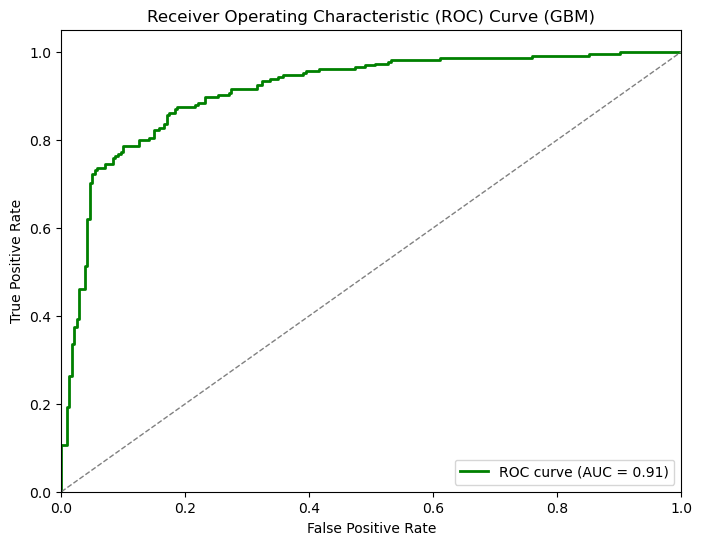

In [40]:
## GBM EVALUATION METRICS
# GBM accuracy with optimal parameters
accuracy_gbm_fft = accuracy_score(y_test_fft, y_pred_gbm_fft)
print("Accuracy (GBM with best parameters):", accuracy_gbm_fft)

# Confusion Matrix
cm_gbm_fft = confusion_matrix(y_test_fft, y_pred_gbm_fft)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbm_fft, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix (GBM with best parameters)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision
precision_gbm_fft = precision_score(y_test_fft, y_pred_gbm_fft)
print("Precision (GBM):", precision_gbm_fft)

# Recall (Sensitivity)
recall_gbm_fft = recall_score(y_test_fft, y_pred_gbm_fft)
print("Recall (GBM):", recall_gbm_fft)

# F1 Score
f1_gbm_fft = f1_score(y_test_fft, y_pred_gbm_fft)
print("F1 Score (GBM):", f1_gbm_fft)

# ROC Curve and AUC
fpr_gbm_fft, tpr_gbm_fft, thresholds_gbm_fft = roc_curve(y_test_fft, best_gbm_model_fft.predict_proba(X_test_pca)[:, 1])
roc_auc_gbm_fft = auc(fpr_gbm_fft, tpr_gbm_fft)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm_fft, tpr_gbm_fft, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_gbm_fft)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (GBM)')
plt.legend(loc="lower right")
plt.show()

In [41]:
## CLASSIFICATION ACCURACY OBTAINED THROUGH 5-FOLD CROSS-VALIDATION

# Feature scaling 
scaler = StandardScaler()
X_scaled_fft = scaler.fit_transform(X_fft)
#PCA
pca_cv = PCA(n_components=10)
X_pca = pca_cv.fit_transform(X_scaled_fft)


# SVM accuracy obtained through cross-validation
svm_cv_acc_fft = cross_val_score(best_svm_model_fft, X_pca, y_fft, cv=5, scoring='accuracy')
print("SVM Cross-Validation Accuracy:", svm_cv_acc_fft.mean())

# GBM accuracy obtained through cross-validation
gbm_cv_acc_fft = cross_val_score(best_gbm_model_fft, X_pca, y_fft, cv=5, scoring='accuracy')
print("GBM Cross-Validation Accuracy:", gbm_cv_acc_fft.mean())


SVM Cross-Validation Accuracy: 0.7870967741935484
GBM Cross-Validation Accuracy: 0.9048387096774192


3. USING DWT APPROXIMATION COEFFICIENTS AS INPUT DATA FOR WIND BLADE DAMAGE DETECTION 

In [42]:
##DISCRETE WAVELET TRANSFORM
#Applying DWT and extracting 4th level approximation coefficients
def dwt_transf(signal):
    coeffs = pywt.wavedec(signal, 'db1', level=4)
    approx_4 = coeffs[0]  # Approximation coefficients (cA_4)
    coefficients = []
    coefficients.extend(approx_4)
    return coefficients

# Applying DWT to each observation in the 'observations_df'
observations_df['DWT_Coefficients'] = observations_df['Signal'].apply(dwt_transf)

# Creating new data frame containing DWT approximation coefficients and labels
labels = observations_df['Label']
DWT_df = pd.DataFrame(observations_df['DWT_Coefficients'].tolist(), index=observations_df.index)
DWT_df['Label'] = labels

# Displaying resulting data frame and its shape
print(DWT_df.head())
print(DWT_df.shape)

          0         1         2         3         4         5         6  \
0  0.109370  0.109218  0.110093  0.111468  0.111075  0.107510  0.102515   
1  0.097610  0.098675  0.096525  0.090695  0.083975  0.079270  0.076458   
2  0.109935  0.103718  0.096528  0.090498  0.085943  0.081685  0.077575   
3  0.083275  0.083560  0.085005  0.087023  0.090240  0.095025  0.100633   
4  0.100478  0.098555  0.097568  0.098340  0.099523  0.099715  0.099178   

          7         8         9  ...        54        55        56        57  \
0  0.099368  0.098858  0.098223  ...  0.079345  0.080068  0.079945  0.081198   
1  0.073370  0.069138  0.066113  ...  0.082693  0.085610  0.092073  0.100048   
2  0.075908  0.078883  0.085635  ...  0.106180  0.107300  0.106320  0.104640   
3  0.105670  0.108735  0.109603  ...  0.111668  0.110375  0.108213  0.104635   
4  0.099160  0.100233  0.101955  ...  0.106598  0.108090  0.109208  0.110865   

         58        59        60        61        62  Label  
0  0.08

In [43]:
# Extract features and labels
X_dwt = DWT_df.drop('Label', axis=1)  
y_dwt = DWT_df['Label'] 

#Split the data into training and testing subsets
X_train_dwt, X_test_dwt, y_train_dwt, y_test_dwt = train_test_split(X_dwt, y_dwt, test_size=0.25, random_state=1)

# Scale the features
scaler = StandardScaler()
X_train_scaled_dwt = scaler.fit_transform(X_train_dwt)
X_test_scaled_dwt = scaler.transform(X_test_dwt)

In [44]:
## PLEASE RUN THIS CODE TO DIRECTLY USE THE OPTIMAL MODEL PARAMETERS OBTAINED FROM HYPERPARAMETER TUNING, AND PROVIDED HERE FOR 
## YOUR CONVENIENCE TO SAVE TIME. IF NEEDED, PLEASE UNCOMMENT AND RUN THE SUBSEQUENT CHUNK OF CODE TO PERFORM HYPERPARAMETER TUNING.

# Optimal parameters for SVM:
# {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
best_params_svm_dwt = {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}

In [47]:
# ## HYPERPARAMETER TUNING FOR KERNELIZED SVM
# # Parameter grid
# param_grid_svm = {
#     'C': [0.1, 1, 10, 100, 1000],  
#     'gamma': [1, 0.1, 0.01, 0.001],  
#     'kernel': ['rbf', 'poly', 'sigmoid'],
#     'degree': [2, 3, 4]
# }

# # Grid search object
# grid_search_svm = GridSearchCV(estimator=SVC(random_state=1),
#                                param_grid=param_grid_svm,
#                                scoring='accuracy',
#                                cv=5,
#                                n_jobs=-1)

# grid_search_svm.fit(X_train_scaled_dwt, y_train_dwt)

# # Optimal parameters
# best_params_svm_dwt = grid_search_svm.best_params_
# print("Optimal Parameters (SVM):", best_params_svm_dwt)

Optimal Parameters (SVM): {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}


In [45]:
# SVM with optimal parameters
best_svm_model_dwt = SVC(**best_params_svm_dwt, probability=True, random_state=1)

# Train the model with the optimal parameters
best_svm_model_dwt.fit(X_train_scaled_dwt, y_train_dwt)

# Predictions on the test data
y_pred_svm_dwt = best_svm_model_dwt.predict(X_test_scaled_dwt)

Accuracy (SVM with best parameters): 0.9913978494623656


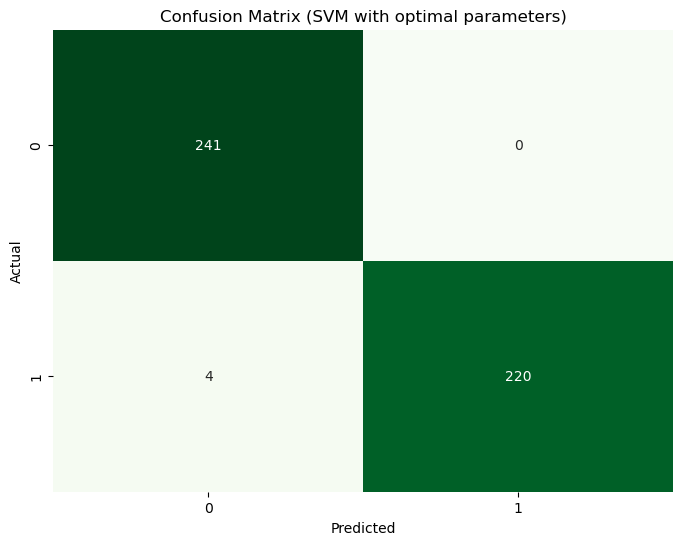

Precision (SVM): 1.0
Recall (SVM): 0.9821428571428571
F1 Score (SVM): 0.9909909909909909


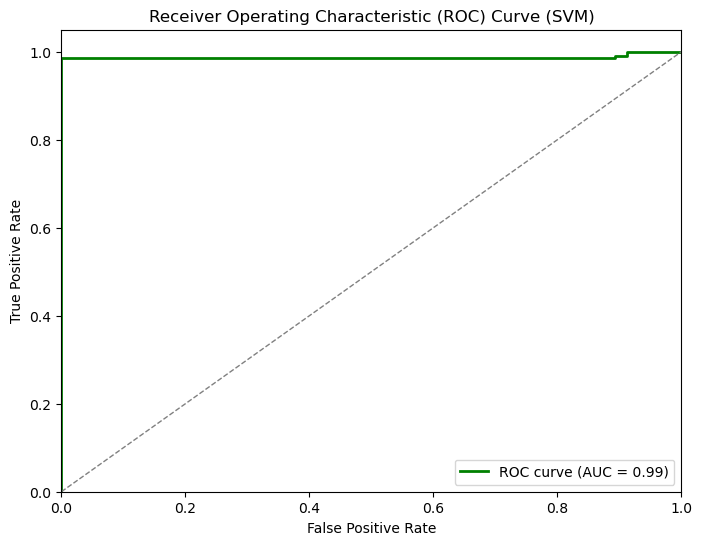

In [46]:
## SVM EVALUATION METRICS
# SVM accuracy with optimal parameters
accuracy_svm_dwt = accuracy_score(y_test_dwt, y_pred_svm_dwt)
print("Accuracy (SVM with best parameters):", accuracy_svm_dwt)

# Confusion Matrix
cm_svm_dwt = confusion_matrix(y_test_dwt, y_pred_svm_dwt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_dwt, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix (SVM with optimal parameters)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision
precision_svm_dwt = precision_score(y_test_dwt, y_pred_svm_dwt)
print("Precision (SVM):", precision_svm_dwt)

# Recall (Sensitivity)
recall_svm_dwt = recall_score(y_test_dwt, y_pred_svm_dwt)
print("Recall (SVM):", recall_svm_dwt)

# F1 Score
f1_svm_dwt = f1_score(y_test_dwt, y_pred_svm_dwt)
print("F1 Score (SVM):", f1_svm_dwt)

# ROC Curve and AUC
fpr_svm_dwt, tpr_svm_dwt, thresholds_svm_dwt = roc_curve(y_test_dwt, best_svm_model_dwt.predict_proba(X_test_scaled_dwt)[:, 1])
roc_auc_svm_dwt = auc(fpr_svm_dwt, tpr_svm_dwt)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm_dwt, tpr_svm_dwt, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_svm_dwt)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (SVM)')
plt.legend(loc="lower right")
plt.show()

In [47]:
## PLEASE RUN THIS CODE TO DIRECTLY USE THE OPTIMAL MODEL PARAMETERS OBTAINED FROM HYPERPARAMETER TUNING, AND PROVIDED HERE FOR 
## YOUR CONVENIENCE TO SAVE TIME. IF NEEDED, PLEASE UNCOMMENT AND RUN THE SUBSEQUENT CHUNK OF CODE TO PERFORM HYPERPARAMETER TUNING.

# Optimal Parameters for GBM: 
# {'learning_rate': 0.5, 'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 500}
best_params_gbm_dwt = {'learning_rate': 0.5, 'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 500}

In [50]:
# ##HYPERPARAMETER TUNING FOR GBM
# #Parameter grid
# param_grid = {
#     'n_estimators': [100, 500, 1000],  # Number of trees
#     'learning_rate': [0.01, 0.1, 0.5],  # Learning rate
#     'max_depth': [3, 4, 5, 9],  # Maximum depth of tree
#     'min_samples_split': [2, 5, 10]  # Minimum number of samples to split the node
# }

# #Grid search object
# grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1),
#                            param_grid=param_grid,
#                            scoring='accuracy',
#                            cv=3,
#                            n_jobs=-1)

# grid_search.fit(X_train_scaled_dwt, y_train_dwt)

# #Optimal parameters
# best_params_gbm_dwt = grid_search.best_params_
# print("Optimal Parameters:", best_params_gbm_dwt)

Optimal Parameters: {'learning_rate': 0.5, 'max_depth': 9, 'min_samples_split': 2, 'n_estimators': 500}


In [48]:
#GBM with optimal parameters
best_gbm_model_dwt = GradientBoostingClassifier(**best_params_gbm_dwt, random_state=1)

# Train the model with the optimal parameters
best_gbm_model_dwt.fit(X_train_scaled_dwt, y_train_dwt)

# Predictions on the test data
y_pred_gbm_dwt = best_gbm_model_dwt.predict(X_test_scaled_dwt)

Accuracy (GBM with best parameters): 0.8731182795698925


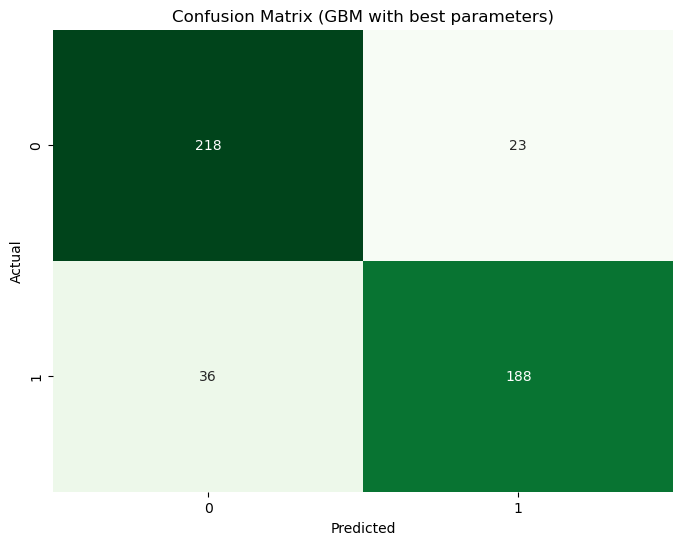

Precision (GBM): 0.8909952606635071
Recall (GBM): 0.8392857142857143
F1 Score (GBM): 0.864367816091954


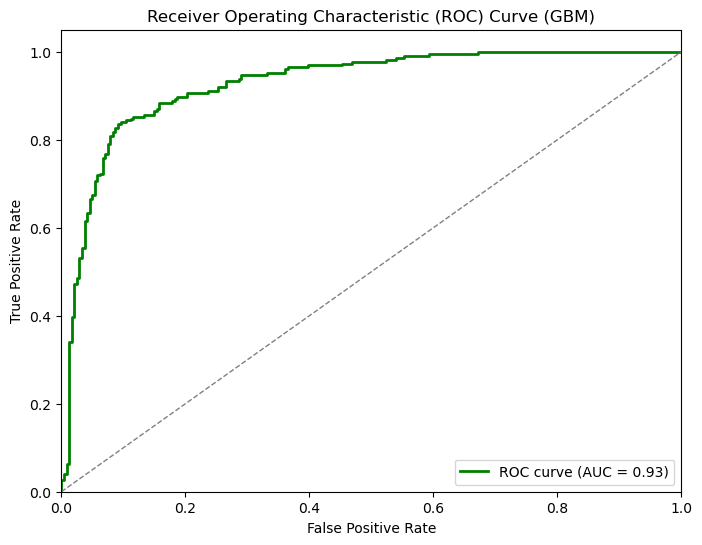

In [49]:
## GBM EVALUATION METRICS
# GBM accuracy with optimal parameters
accuracy_gbm_dwt = accuracy_score(y_test_dwt, y_pred_gbm_dwt)
print("Accuracy (GBM with best parameters):", accuracy_gbm_dwt)

# Confusion Matrix
cm_gbm_dwt = confusion_matrix(y_test_dwt, y_pred_gbm_dwt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbm_dwt, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix (GBM with best parameters)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision
precision_gbm_dwt = precision_score(y_test_dwt, y_pred_gbm_dwt)
print("Precision (GBM):", precision_gbm_dwt)

# Recall (Sensitivity)
recall_gbm_dwt = recall_score(y_test_dwt, y_pred_gbm_dwt)
print("Recall (GBM):", recall_gbm_dwt)

# F1 Score
f1_gbm_dwt = f1_score(y_test_dwt, y_pred_gbm_dwt)
print("F1 Score (GBM):", f1_gbm_dwt)

# ROC Curve and AUC
fpr_gbm_dwt, tpr_gbm_dwt, thresholds_gbm_dwt = roc_curve(y_test_dwt, best_gbm_model_dwt.predict_proba(X_test_scaled_dwt)[:, 1])
roc_auc_gbm_dwt = auc(fpr_gbm_dwt, tpr_gbm_dwt)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm_dwt, tpr_gbm_dwt, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_gbm_dwt)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (GBM)')
plt.legend(loc="lower right")
plt.show()

In [50]:
## CLASSIFICATION ACCURACY OBTAINED THROUGH 5-FOLD CROSS-VALIDATION

# Feature scaling 
scaler = StandardScaler()
X_scaled_dwt = scaler.fit_transform(X_dwt)

# SVM accuracy obtained through cross-validation
svm_cv_acc_dwt = cross_val_score(best_svm_model_dwt, X_scaled_dwt, y_dwt, cv=5, scoring='accuracy')
print("SVM Cross-Validation Accuracy:", svm_cv_acc_dwt.mean())

# GBM accuracy obtained through cross-validation
gbm_cv_acc_dwt = cross_val_score(best_gbm_model_dwt, X_scaled_dwt, y_dwt, cv=5, scoring='accuracy')
print("GBM Cross-Validation Accuracy:", gbm_cv_acc_dwt.mean())


SVM Cross-Validation Accuracy: 0.9983870967741936
GBM Cross-Validation Accuracy: 0.9344086021505376


4. USING SCATTERING WAVELET TRANSFORMS REPRESENTATIONS AS INPUT DATA FOR WIND BLADE DAMAGE DETECTION 

In [51]:
#SCATTERING WAVELET TRANSFORMS

# Function to compute scattering wavelet transforms
def scattering_transform(signal):
    scattering = Scattering1D(J=4, shape=(len(signal),))
    # Compute scattering transform
    Sx = scattering(np.array(signal))
    # Extract coefficients from the last scale
    last_scale_coeff = Sx[-1]
    return last_scale_coeff.tolist()

# Compute scattering transform for each observation
observations_df['Last_Scale_Coeff'] = observations_df['Signal'].apply(scattering_transform)

# Create a new data set with extracted coefficients and labels
SWT_df = pd.DataFrame(observations_df['Last_Scale_Coeff'].tolist())
SWT_df['Label'] = observations_df['Label']

print(SWT_df.head())

              0             1             2             3             4  \
0  2.796785e-07  3.227500e-07  4.337822e-07  6.191363e-07  8.475794e-07   
1  1.292246e-06  1.337621e-06  1.399731e-06  1.428307e-06  1.412639e-06   
2  7.287371e-07  7.275621e-07  7.374692e-07  7.538828e-07  7.631751e-07   
3  3.094756e-07  3.319346e-07  3.891433e-07  4.704516e-07  5.463316e-07   
4  3.557687e-07  3.381215e-07  3.033010e-07  2.629454e-07  2.271075e-07   

              5             6             7             8             9  ...  \
0  1.054474e-06  1.191074e-06  1.249825e-06  1.245391e-06  1.194577e-06  ...   
1  1.360515e-06  1.277059e-06  1.181217e-06  1.112321e-06  1.095962e-06  ...   
2  7.913710e-07  8.794232e-07  1.010957e-06  1.112633e-06  1.130599e-06  ...   
3  6.026807e-07  6.481485e-07  6.766117e-07  6.585497e-07  5.893646e-07  ...   
4  2.037969e-07  2.002910e-07  2.162128e-07  2.470515e-07  2.988252e-07  ...   

             54            55            56            57           

In [52]:
first_signal = observations_df.loc[0, 'Signal']
#print(len(first_signal))
scattering = Scattering1D(J=4, shape=(len(first_signal),))
# Compute scattering transform
Sx = scattering(np.array(first_signal))
print(Sx.shape)


(13, 63)


In [53]:
# Extract features and labels
X_swt = SWT_df.drop('Label', axis=1)  
y_swt = SWT_df['Label']  

# Split the data set into training and testing subsets
X_train_swt, X_test_swt, y_train_swt, y_test_swt = train_test_split(X_swt, y_swt, test_size=0.25, random_state=1)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled_swt = scaler.fit_transform(X_train_swt)
X_test_scaled_swt = scaler.transform(X_test_swt)

In [54]:
## PLEASE RUN THIS CODE TO DIRECTLY USE THE OPTIMAL MODEL PARAMETERS OBTAINED FROM HYPERPARAMETER TUNING, AND PROVIDED HERE FOR 
## YOUR CONVENIENCE TO SAVE TIME. IF NEEDED, PLEASE UNCOMMENT AND RUN THE SUBSEQUENT CHUNK OF CODE TO PERFORM HYPERPARAMETER TUNING.

# Optimal parameters for SVM:
# {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
best_params_svm_swt = {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}

In [59]:
# ## HYPERPARAMETER TUNING FOR KERNELIZED SVM
# # Parameter grid
# param_grid_svm = {
#     'C': [0.1, 1, 10, 100, 1000],  
#     'gamma': [1, 0.1, 0.01, 0.001],  
#     'kernel': ['rbf', 'sigmoid']
    
# }

# # Grid search object
# grid_search_svm = GridSearchCV(estimator=SVC(random_state=1),
#                                param_grid=param_grid_svm,
#                                scoring='accuracy',
#                                cv=5,
#                                n_jobs=-1)

# grid_search_svm.fit(X_train_scaled_swt, y_train_swt)

# # Optimal parameters
# best_params_svm_swt = grid_search_svm.best_params_
# print("Optimal Parameters (SVM):", best_params_svm_swt)

Optimal Parameters (SVM): {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [55]:
# SVM with optimal parameters
best_svm_model_swt = SVC(**best_params_svm_swt, probability=True, random_state=1)

# Train the model with the optimal parameters
best_svm_model_swt.fit(X_train_scaled_swt, y_train_swt)

# Predictions on the test data
y_pred_svm_swt = best_svm_model_swt.predict(X_test_scaled_swt)

Accuracy (SVM with best parameters): 0.9053763440860215


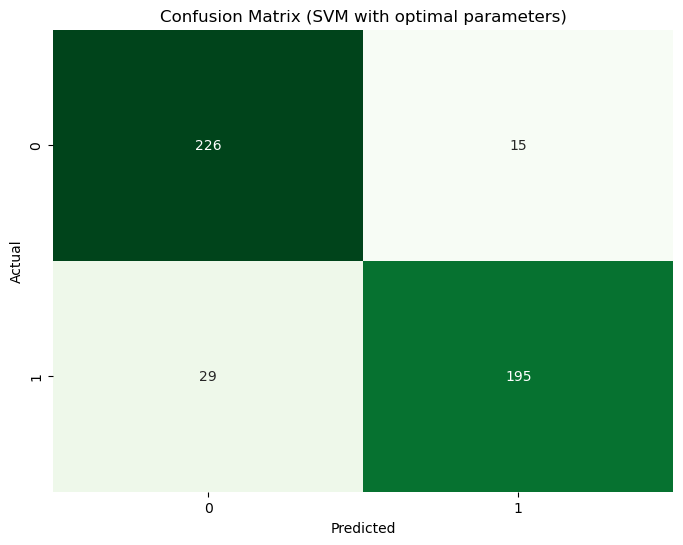

Precision (SVM): 0.9285714285714286
Recall (SVM): 0.8705357142857143
F1 Score (SVM): 0.8986175115207374


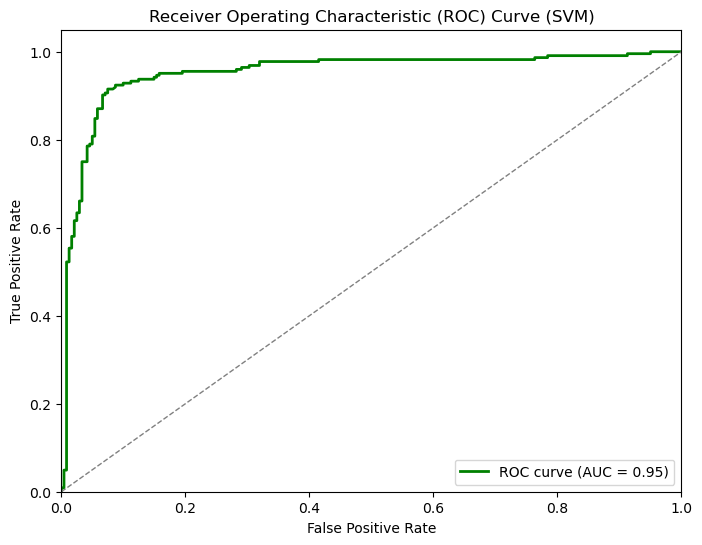

In [56]:
## SVM EVALUATION METRICS
# SVM accuracy with optimal parameters
accuracy_svm_swt = accuracy_score(y_test_swt, y_pred_svm_swt)
print("Accuracy (SVM with best parameters):", accuracy_svm_swt)

# Confusion Matrix
cm_svm_swt = confusion_matrix(y_test_swt, y_pred_svm_swt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_swt, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix (SVM with optimal parameters)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision
precision_svm_swt = precision_score(y_test_swt, y_pred_svm_swt)
print("Precision (SVM):", precision_svm_swt)

# Recall (Sensitivity)
recall_svm_swt = recall_score(y_test_swt, y_pred_svm_swt)
print("Recall (SVM):", recall_svm_swt)

# F1 Score
f1_svm_swt = f1_score(y_test_swt, y_pred_svm_swt)
print("F1 Score (SVM):", f1_svm_swt)

# ROC Curve and AUC
fpr_svm_swt, tpr_svm_swt, thresholds_svm_swt = roc_curve(y_test_swt, best_svm_model_swt.predict_proba(X_test_scaled_swt)[:, 1])
roc_auc_svm_swt = auc(fpr_svm_swt, tpr_svm_swt)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm_swt, tpr_svm_swt, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_svm_swt)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (SVM)')
plt.legend(loc="lower right")
plt.show()

In [57]:
## PLEASE RUN THIS CODE TO DIRECTLY USE THE OPTIMAL MODEL PARAMETERS OBTAINED FROM HYPERPARAMETER TUNING, AND PROVIDED HERE FOR 
## YOUR CONVENIENCE TO SAVE TIME. IF NEEDED, PLEASE UNCOMMENT AND RUN THE SUBSEQUENT CHUNK OF CODE TO PERFORM HYPERPARAMETER TUNING.

# Optimal Parameters for GBM: 
# {'learning_rate': 0.9, 'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 400}
best_params_gbm_swt = {'learning_rate': 0.9, 'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 400}

In [58]:
# ##HYPERPARAMETER TUNING FOR GBM
# #Parameter grid
# param_grid = {
#     'n_estimators': [400, 500, 700],  # Number of trees
#     'learning_rate': [0.5, 0.8, 0.9],  # Learning rate
#     'max_depth': [10, 12, 14],  # Maximum depth of tree
#     'min_samples_split': [3, 5, 7]  # Minimum number of samples to split the node
# }

# #Grid search object
# grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=1),
#                            param_grid=param_grid,
#                            scoring='accuracy',
#                            cv=3,
#                            n_jobs=-1)

# grid_search.fit(X_train_scaled_swt, y_train_swt)

# #Optimal parameters
# best_params_gbm_swt = grid_search.best_params_
# print("Optimal Parameters:", best_params_gbm_swt)

In [59]:
#GBM with optimal parameters
best_gbm_model_swt = GradientBoostingClassifier(**best_params_gbm_swt, random_state=1)

# Train the model with the optimal parameters
best_gbm_model_swt.fit(X_train_scaled_swt, y_train_swt)

# Predictions on the test data
y_pred_gbm_swt = best_gbm_model_swt.predict(X_test_scaled_swt)

Accuracy (GBM with best parameters): 0.7032258064516129


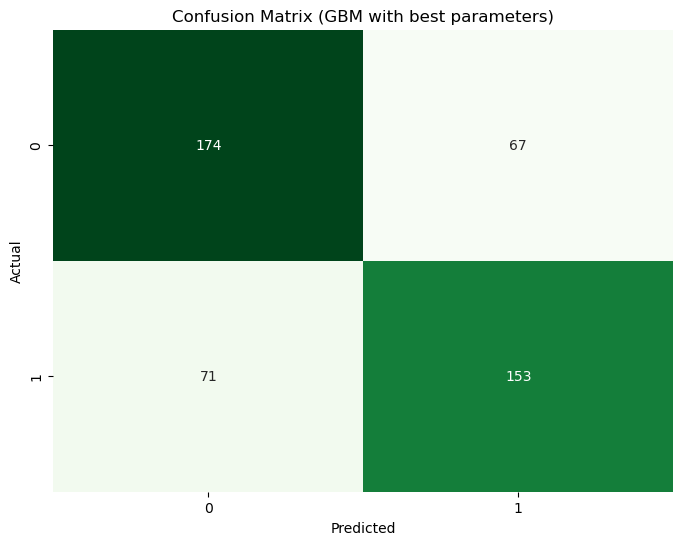

Precision (GBM): 0.6954545454545454
Recall (GBM): 0.6830357142857143
F1 Score (GBM): 0.6891891891891891


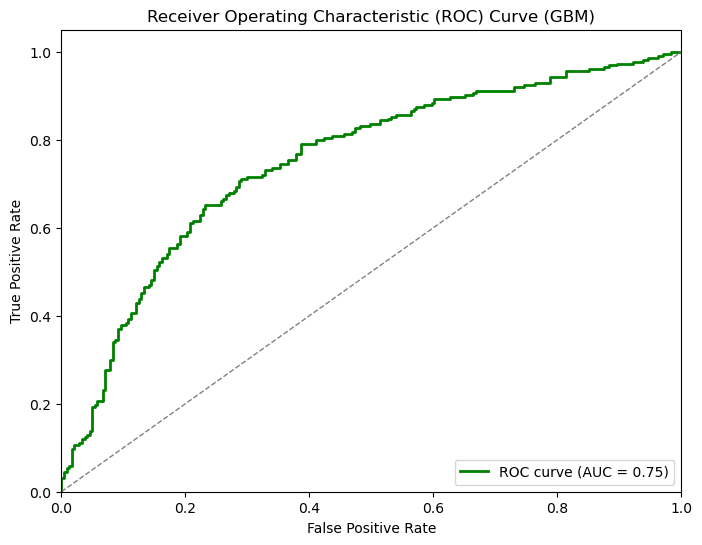

In [60]:
## GBM EVALUATION METRICS
# GBM accuracy with optimal parameters
accuracy_gbm_swt = accuracy_score(y_test_swt, y_pred_gbm_swt)
print("Accuracy (GBM with best parameters):", accuracy_gbm_swt)

# Confusion Matrix
cm_gbm_swt = confusion_matrix(y_test_swt, y_pred_gbm_swt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gbm_swt, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix (GBM with best parameters)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision
precision_gbm_swt = precision_score(y_test_swt, y_pred_gbm_swt)
print("Precision (GBM):", precision_gbm_swt)

# Recall (Sensitivity)
recall_gbm_swt = recall_score(y_test_swt, y_pred_gbm_swt)
print("Recall (GBM):", recall_gbm_swt)

# F1 Score
f1_gbm_swt = f1_score(y_test_swt, y_pred_gbm_swt)
print("F1 Score (GBM):", f1_gbm_swt)

# ROC Curve and AUC
fpr_gbm_swt, tpr_gbm_swt, thresholds_gbm_swt = roc_curve(y_test_swt, best_gbm_model_swt.predict_proba(X_test_scaled_swt)[:, 1])
roc_auc_gbm_swt = auc(fpr_gbm_swt, tpr_gbm_swt)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm_swt, tpr_gbm_swt, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_gbm_swt)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (GBM)')
plt.legend(loc="lower right")
plt.show()

In [61]:
## CLASSIFICATION ACCURACY OBTAINED THROUGH 5-FOLD CROSS-VALIDATION

# Feature scaling 
scaler = StandardScaler()
X_scaled_swt = scaler.fit_transform(X_swt)

# SVM accuracy obtained through cross-validation
svm_cv_acc_swt = cross_val_score(best_svm_model_swt, X_scaled_swt, y_swt, cv=5, scoring='accuracy')
print("SVM Cross-Validation Accuracy:", svm_cv_acc_swt.mean())

# GBM accuracy obtained through cross-validation
gbm_cv_acc_swt = cross_val_score(best_gbm_model_swt, X_scaled_swt, y_swt, cv=5, scoring='accuracy')
print("GBM Cross-Validation Accuracy:", gbm_cv_acc_swt.mean())

SVM Cross-Validation Accuracy: 0.9666666666666668
GBM Cross-Validation Accuracy: 0.786021505376344
